# Students versus Professionals 

In [12]:
import glob, random
import numpy as np
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import tensorflow as tf
import keras.backend as K
#keras works on tensorflow
import tensorflow as tf
import keras
tf.VERSION,keras.__version__

('1.10.0', '2.0.9')

In [3]:
numpy.random.seed(7)

In [4]:
#How the data looks like
datdir = "/Users/yuribizzoni/Downloads/Translation/B7/Ekat/"
original = open(datdir+"croco_for_english_study/GO/GO_ESSAY_001.conllu").read()

In [5]:
#
#Make sequences of German original tags

#1. for the new data: we need a pos-extracting function

def pos_extraction(line):
    final = ""
    if line.startswith("# sent"): final+="\n"
    elif line.startswith("#"): pass
    elif len(line)<2: pass
    else: 
        tab = line.split("\t")
        if len(tab)==10:
            pos=tab[3]
            final+=pos+" "
    return final
    
    

def make_poseq(original):
    originaline = original.split("\n")
    final=""""""
    for line in originaline:
        final+=pos_extraction(line)
    final = final.replace("_","")
    return final


def register_calibrated_dataset(n_sentences_for_register, address_names):
    final = ""
    prv = []
    for name in address_names:
        original = open(name).read()
        pos = make_poseq(original)
        prv.append(pos.split("\n"))
    for el in prv: 
        stri="\n".join(el[:n_sentences_for_register])
        final+=stri
    return final


def poseq(globaddress, random_=False, one_each=0, text_too=False):
    
    # One_each = if >0, it means how many of each register you want to include
    # Random = is the selection randomized?

    names = glob.glob(globaddress)
    
    final = """"""
    
    if one_each>0:
        final+=register_calibrated_dataset(one_each, names)
        
    else:
        for name in names:
            original = open(name).read()
            final+=make_poseq(original)
    if random_: 
        fin = final.split("\n")
        random.shuffle(fin)
        final = "\n".join(fin)
    return final



In [6]:
original = open(datdir+"croco_for_english_study/GO/GO_ESSAY_001.conllu").read()
deusenPOS = poseq(datdir+"croco_for_english_study/GO/*", one_each=3, random_=False)
print(len(deusenPOS))
print(deusenPOS[:400])

27638

PRON VERB PRON ADV ADV ADP DET ADJ NOUN PUNCT SCONJ DET ADJ NOUN ADV VERB PUNCT 
ADJ ADV PUNCT AUX PRON PRON ADJ NOUN VERB PUNCT 
NOUN PUNCT NOUN DET NOUN 
 ADP DET NOUN PUNCT  ADP DET ADJ NOUN CCONJ ADV ADP DET NOUN PRON PRON NOUN VERB DET PUNCT PROPN PUNCT NOUN PRON NOUN ADP DET NOUN ADJ NOUN ADJ PUNCT 
NOUN NOUN PUNCT PRON NOUN CCONJ NOUN PUNCT ADV VERB PRON DET ADJ ADJ NOUN ADP DET PROPN PROP


In [7]:
# how large is our vocabulary?
tok = deusenPOS.split()
len(set(tok))

15

# Making and training the LSTM model

In [8]:
#Preprocessing

tokenizer = Tokenizer()
tokenizer.fit_on_texts([deusenPOS])
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

16


In [9]:
tokenizer.word_index # each PoS has an index number

{'noun': 1,
 'punct': 2,
 'det': 3,
 'adp': 4,
 'propn': 5,
 'adj': 6,
 'verb': 7,
 'pron': 8,
 'adv': 9,
 'cconj': 10,
 'aux': 11,
 'num': 12,
 'part': 13,
 'sconj': 14,
 'x': 15}

In [17]:
#Turn POS into one-shot-vecs

#We need a max sentence length. 
#Emipirically, I will fix it to 252, the longest sequence of both corpora.
max_length = 252 #can also be made as long as mean+std length 


sequences = list()
for line in deusenPOS.split("\n"):
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)


print('Total Sequences: %d' % len(sequences))
print('Max Sequence Length: %d' % max_length) 
print('Vocabulary Size: %d' % vocab_size)

# pad input sequences
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

import random
random.shuffle(sequences)

# split into input and output elements
sequences = array(sequences)
Xde_or, y = sequences[:,:-1],sequences[:,-1]
yde_or = to_categorical(y, num_classes=vocab_size)

Total Sequences: 5342
Max Sequence Length: 252
Vocabulary Size: 16


In [92]:
# define perplexity
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred) 
    perplexity = K.pow(2.0, cross_entropy) 
    return perplexity

In [18]:
def model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length-1))
    model.add(LSTM(50))
    model.add(Dense(vocab_size, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[perplexity])
    return model

In [19]:
# X/Y split
n=70000
print(len(Xde_or)) #DeOr = Deutsch Original
trainX_deor = Xde_or[:n]
trainY_deor = yde_or[:n]

print(Xde_or.shape, yde_or.shape, trainX_deor.shape, trainY_deor.shape)

5342
(5342, 251) (5342, 16) (5342, 251) (5342, 16)


In [95]:
# fit and evaluate the network

model_deor = model(vocab_size)

model_deor.fit(trainX_deor, trainY_deor, epochs=2, verbose=1, validation_split=.2)
#increase epochs as necessary ofc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 29, 10)            160       
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                816       
Total params: 13,176
Trainable params: 13,176
Non-trainable params: 0
_________________________________________________________________
None
Train on 4273 samples, validate on 1069 samples
Epoch 1/2
4273/4273 [==============================] - 4s 884us/step - loss: 0.9811 - perplexity: 4.6180 - val_loss: 0.8420 - val_perplexity: 4.6337
Epoch 2/2
4273/4273 [==============================] - 3s 616us/step - loss: 0.5497 - perplexity: 2.8983 - val_loss: 0.5441 - val_perplexity: 2.3412


In [96]:
model_deor.evaluate(Xde_or[:],yde_or[:], verbose=1)

5342/5342 [==============================] - 1s 97us/step


[0.4170505398558749, 1.96663568181431]

In [21]:
# We now take the Eglish translations
english_tra_tag = """"""
tratag1 = poseq(datdir+"croco_for_english_study/PT/*") # professionals' PoS
tratag2 = poseq(datdir+"croco_for_english_study/ST/*") # students' PoS
english_tra_tag = tratag1+tratag2 # all together

In [22]:
# this is how the data looks like
print(english_tra_tag[:500])


PRON NOUN PRON ADV ADJ ADP DET NOUN ADV ADP DET NOUN PROPN PUNCT 
DET ADJ NOUN VERB ADV ADP NOUN PUNCT CCONJ PRON VERB PUNCT PRON AUX PRON VERB PUNCT PRON ADP PRON ADV ADJ PUNCT 
DET NOUN VERB ADV ADV ADV NUM NOUN ADJ ADP VERB PUNCT SCONJ PRON ADV PROPN NOUN ADP NUM NOUN PRON NOUN VERB CCONJ DET NOUN ADP PRON ADJ NOUN VERB PUNCT 
SCONJ ADV NOUN PUNCT 
NOUN CCONJ DET NOUN ADP PRON NOUN ADJ VERB AUX PUNCT VERB PRON PRON ADV ADV ADJ DET NOUN VERB PUNCT SCONJ PROPN PROPN ADP PRON NOUN ADV  ADP DET 


In [23]:
# Again, we preprocess the English data this time for training

sequences = list()
lines = []
for line in english_tra_tag.split('\n'):
    lines.append(line)
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# pad input sequences
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Max Sequence Length: %d' % max_length)

print("Number of Lines: %d " % len(lines))

# split into input and output elements
sequences = array(sequences)
X_entra, y1 = sequences[:,:-1],sequences[:,-1]
y_entra = to_categorical(y1, num_classes=vocab_size)


Total Sequences: 374765
Max Sequence Length: 252
Number of Lines: 17814 


In [102]:
# X/Y split
n = 1000 
X_entr, y_entr = X_entra[:n], y_entra[:n]

In [103]:
#Test original German model on all translations
model_deor.evaluate(X_entr,y_entr, verbose=1) 

1000/1000 [==============================] - 0s 120us/step


[0.5129205535948277, 2.317960334777832]

In [104]:
#Only students
english_tagCAT = tratag2

In [105]:
# evaluating only the students
sequences = list()
lines = []

for line in english_tagCAT.split('\n'):
    lines.append(line)
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# pad input sequences
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Max Sequence Length: %d' % max_length)

# split into input and output elements
sequences_st = array(sequences)
X1_st, y1_st = sequences_st[:,:-1],sequences_st[:,-1]
y1_st = to_categorical(y1_st, num_classes=vocab_size)

Total Sequences: 135770
Max Sequence Length: 30


In [106]:
#testing the students
X_entra_st, y_entra_st = X1_st[:1000], y1_st[:1000]

In [ ]:
#Evaluating only professionals

import random
names = glob.glob(datdir+"vartra/pos-repres/PT_*.txt")

In [24]:
# I will write a function that will turn a global address into an X and Y dataset
# Ready to split

def old_processing(global_address): # just in case we need to process strange encodings
    data = """"""
    i=0
    names = glob.glob(global_address)
    for name in names:
        try: 
            prv = open(name).read()
            data+=prv
        except (UnicodeDecodeError): print("Unicode Error")
        i+=1
    print(len(data))
    return data


def make_sequences(data, breaker):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([data])
    sequences = list()
    c = 0 
    broken_data = data.split(breaker)
    for line in broken_data:
        c+=1
        encoded = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[:i+1]
            sequences.append(sequence)
    print('Total Sequences: %d' % len(sequences))
    print("number of lines: ", c)
    return sequences

def from_sequences_to_x_and_y(sequences):
    sequences = array(sequences)
    X, y = sequences[:,:-1],sequences[:,-1]
    Y = to_categorical(y, num_classes=vocab_size)
    return X, Y
    
    
def X_and_Y(globaddress, one_each=0,old=False, random_shuff=True,
            breaker="\n",max_length=-1,vocab_size=-1):
    
    if old: data = old_processing(globaddress)
        
    else: data = poseq(globaddress, random_=random_shuff, one_each=one_each)

    # sequences
    sequences = make_sequences(data, breaker)

    # pad input sequences
    if max_length == -1:
        max_length = max([len(seq) for seq in sequences]) #> we keep the original length
        print("max length set to: "+str(max_length))
    
    if vocab_size == -1:
        vocab_size = len(tokenizer.word_index) + 1
        print("vocabulary size set to: "+str(vocab_size))
    
    sequences = pad_sequences(sequences, maxlen=max_length, padding='pre', truncating='pre')

    # split into input and output elements
    X, Y = from_sequences_to_x_and_y(sequences)
    
    return X, Y

X1_pt, y1_pt = X_and_Y(datdir+"croco_for_english_study/PT/*",one_each=5,
                      max_length=30, vocab_size=vocab_size)

Total Sequences: 8766
number of lines:  393


In [109]:
#Only professionals
n=1000
X_entra_pr, y_entra_pr= X1_pt[:n], y1_pt[:n]

In [25]:
eva = model_deor.evaluate(X_entra_pr,y_entra_pr, verbose=1) #professionals are structurally more surprising than students?
print("German model perplexity: ",eva[-1])

NameError: name 'model_deor' is not defined

In [111]:
#Now train the english original model 

X_eot, y_eot = X_and_Y(datdir+"croco_for_english_study/EO/*",one_each=15,
                      max_length=30, vocab_size=18)
X_dot, y_dot = X_and_Y(datdir+"croco_for_english_study/GO/*",one_each=15,
                      max_length=30, vocab_size=18)

X_eo, y_eo = X_and_Y(datdir+"croco_for_english_study/EO/*",one_each=0,
                      max_length=30, vocab_size=18)
X_do, y_do = X_and_Y(datdir+"croco_for_english_study/GO/*",one_each=0,
                      max_length=30, vocab_size=18)

Total Sequences: 31997
number of lines:  1541
Total Sequences: 34161
number of lines:  1695
Total Sequences: 274638
number of lines:  13767
Total Sequences: 275139
number of lines:  14776


In [113]:
Xlab, ylab = X_and_Y(datdir+"croco_for_english_study/EO/*POPSCI*",old=False,
                      max_length=30, vocab_size=18)

Xlabd, ylabd = X_and_Y(datdir+"croco_for_english_study/GO/*POPSCI*",old=False,
                      max_length=30, vocab_size=18)

Total Sequences: 34275
number of lines:  1394
Total Sequences: 34990
number of lines:  1573


In [117]:
model_enor = model(18) ## EnOr = English Original
# fit network

n=30000

trainX_enor = X_eot[:n]
trainY_enor = y_eot[:n]

print(trainX_enor.shape, trainY_enor.shape)
# fit network
model_enor.fit(trainX_enor, trainY_enor, epochs=3, verbose=1, validation_split=.2)#10
#

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 29, 10)            180       
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_9 (Dense)              (None, 18)                918       
Total params: 13,298
Trainable params: 13,298
Non-trainable params: 0
_________________________________________________________________
None
(30000, 29) (30000, 18)
Train on 24000 samples, validate on 6000 samples
Epoch 1/3
24000/24000 [==============================] - 17s 701us/step - loss: 2.2654 - perplexity: 5.8890 - val_loss: 2.0374 - val_perplexity: 5.2177
Epoch 2/3
24000/24000 [==============================] - 17s 713us/step - loss: 1.9881 - perplexity: 5.3685 - val_loss: 1.9453 - val_perplexity: 5.2381
Epoch 3/3
24000/2400

In [122]:
#Are values consistent? randomly sampling from English originals
for i in range(10):
    n=random.randint(3000,len(X_eo))
    #print(n)
    m=n+10000
    res=model_enor.evaluate(X_eo[n:m],y_eo[n:m], verbose=1)
    print(res[1])

10000/10000 [==============================] - 1s 108us/step
10.049359952545165
10000/10000 [==============================] - 1s 104us/step
9.812494881439209
10000/10000 [==============================] - 1s 97us/step
9.845601522827149
10000/10000 [==============================] - 1s 99us/step
9.760291081237792
10000/10000 [==============================] - 1s 100us/step
9.766912847900391
10000/10000 [==============================] - 1s 99us/step
9.865225326538086
10000/10000 [==============================] - 1s 100us/step
9.76642367401123
10000/10000 [==============================] - 1s 101us/step
9.940634385681152
10000/10000 [==============================] - 1s 100us/step
10.198026788330077
10000/10000 [==============================] - 1s 100us/step
9.7982401512146


In [118]:
## A small statistical significance test

from scipy.stats import ttest_ind
n,m=30000,35000
manypers, manypers2 =[],[]
for i in range(n,n+100):
    manypers.append(model_enor.evaluate(X_eot[i-1:i],y_eot[i-1:i], verbose=0)[1])
print(len(manypers))
for i in range(n,n+100):
    manypers2.append(model_enor.evaluate(X_do[i-1:i],y_do[i-1:i], verbose=0)[1])
print(len(manypers2))

ttest_ind(manypers,manypers2)

100
100


Ttest_indResult(statistic=-4.567195893108441, pvalue=8.677525330817084e-06)

In [119]:
#n,m=0,6000
model_enor.evaluate(X_do[:m],y_do[:m], verbose=1) # testing on German Originals

35000/35000 [==============================] - 3s 99us/step


[2.8671653472355434, 12.642070831516811]

In [123]:
## English model's perplexity on some categories of Student translation
# (change n and m if needed)

pnine=[]
setto = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split()
for s in setto:
    print(s)
    Xlab, ylab = X_and_Y(datdir+"croco_for_english_study/EO/*"+s+"*",old=False,
                        max_length=30, vocab_size=18)

    n,m=0,600
    res = model_enor.evaluate(Xlab[n:m],ylab[n:m], verbose=1)[1]
    print(res)
    pnine.append(res)

FICTION
Total Sequences: 35177
number of lines:  1843
600/600 [==============================] - 0s 102us/step
13.74291254679362
ESSAY
Total Sequences: 33700
number of lines:  1539
600/600 [==============================] - 0s 121us/step
8.141197319030761
POPSCI
Total Sequences: 34275
number of lines:  1394
600/600 [==============================] - 0s 110us/step
10.92416840871175
INSTR
Total Sequences: 33865
number of lines:  2464
600/600 [==============================] - 0s 90us/step
11.876731147766113
SHARE
Total Sequences: 34888
number of lines:  1550
600/600 [==============================] - 0s 90us/step
12.216017525990804
SPEECH
Total Sequences: 33628
number of lines:  1596
600/600 [==============================] - 0s 90us/step
9.92010824839274
TOU
Total Sequences: 34360
number of lines:  1622
600/600 [==============================] - 0s 90us/step
10.011533393859864


In [126]:
# Train theDeutsch Original again, with a larger vocab size 
n = 30000
model_deor = model(18)
model_deor.fit(X_dot[:n], y_dot[:n], epochs=3, verbose=1, validation_split=.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 29, 10)            180       
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_10 (Dense)             (None, 18)                918       
Total params: 13,298
Trainable params: 13,298
Non-trainable params: 0
_________________________________________________________________
None
Train on 24000 samples, validate on 6000 samples
Epoch 1/3
24000/24000 [==============================] - 16s 677us/step - loss: 2.1861 - perplexity: 5.5952 - val_loss: 1.9938 - val_perplexity: 5.1262
Epoch 2/3
24000/24000 [==============================] - 15s 642us/step - loss: 1.9454 - perplexity: 5.2283 - val_loss: 1.9068 - val_perplexity: 5.0908
Epoch 3/3
24000/24000 [=====================

In [127]:
len(X_dot)

34161

In [128]:
#labation+
for i in range(10):
    n=random.randint(3000,len(X_do))
    m=n+10000
    res=model_deor.evaluate(X_do[n:m],y_do[n:m], verbose=1)
    print(res[1])

10000/10000 [==============================] - 1s 110us/step
5.802851578521729
10000/10000 [==============================] - 1s 108us/step
6.017208496856689
10000/10000 [==============================] - 1s 102us/step
6.122104619598389
10000/10000 [==============================] - 1s 118us/step
5.908906713104248
10000/10000 [==============================] - 1s 117us/step
5.973938494110107
10000/10000 [==============================] - 1s 104us/step
5.900920376586914
10000/10000 [==============================] - 1s 105us/step
5.968314621734619
10000/10000 [==============================] - 1s 103us/step
5.971332264709472
10000/10000 [==============================] - 1s 97us/step
5.872017536926269
10000/10000 [==============================] - 1s 97us/step
6.029656967926026


In [129]:
from scipy.stats import ttest_ind
n,m=30000,31000
manypers, manypers2 =[],[]
for i in range(n,n+100):
    manypers.append(model_deor.evaluate(X_eot[i-1:i],y_eot[i-1:i], verbose=0)[1])
print(len(manypers))
for i in range(m,m+100):
    #print(i)
    manypers2.append(model_deor.evaluate(X_dot[i-1:i],y_dot[i-1:i], verbose=0)[1])
print(len(manypers2))

ttest_ind(manypers,manypers2)

100
100


Ttest_indResult(statistic=5.023673608984059, pvalue=1.1290991541362082e-06)

In [130]:
n=50000
model_deor.evaluate(X_eo[:n],y_eo[:n], verbose=1)

50000/50000 [==============================] - 5s 97us/step


[3.0167825508117674, 15.366721502685547]

In [131]:
n=8000
for el in """FICTION ESSAY POPSCI TOU""".split():
    print(el)
    Xlab, ylab = X_and_Y(datdir+"croco_for_english_study/GO/*"+el+"*",old=False,
                          max_length=30, vocab_size=18)
    eva=model_enor.evaluate(Xlab[:n],ylab[:n], verbose=1)
    print(eva)

FICTION
Total Sequences: 34972
number of lines:  1942
8000/8000 [==============================] - 1s 97us/step
[3.22089653301239, 15.89577233505249]
ESSAY
Total Sequences: 34395
number of lines:  1768
8000/8000 [==============================] - 1s 97us/step
[2.7872895154953, 11.635519088745117]
POPSCI
Total Sequences: 34990
number of lines:  1573
8000/8000 [==============================] - 1s 96us/step
[2.8127399883270265, 11.139602266311645]
TOU
Total Sequences: 34839
number of lines:  1726
8000/8000 [==============================] - 1s 97us/step
[2.708956852436066, 11.550650247573852]


Are these differences statistically significant? We check

In [155]:
english_perplexity = {"eo":[], "go":[], "gst":[], "gpr":[]}
german_perplexity = {"eo":[],"go":[], "gst":[], "gpr":[]}

In [156]:
X_eot, y_eot = X_and_Y(datdir+"croco_for_english_study/EO/*",one_each=20,
                      max_length=30, vocab_size=18)
X_dot, y_dot = X_and_Y(datdir+"croco_for_english_study/GO/*",one_each=20, 
                      max_length=30, vocab_size=18)

Total Sequences: 43802
number of lines:  2091
Total Sequences: 46572
number of lines:  2300


In [157]:
#We take 100 small random samples and collect the perlexity values of both 
#models

for i in range(100):
    print("\n",i)
    n = int(random.gauss(40000,2000))
    m = n+60
    print(n,m)

    cat="eo"
    #DE - * - EN    eo
    en = model_enor.evaluate(X_eo[n:m],y_eo[n:m], verbose=1)[1]
    de = model_deor.evaluate(X_eo[n:m],y_eo[n:m], verbose=1)[1]
    print(de,en)
    english_perplexity[cat] += [round(en,2)]
    german_perplexity[cat] += [round(de,2)]

    #DE - * - EN   go
    cat = "go"
    en = model_enor.evaluate(X_do[n:m],y_do[n:m], verbose=1)[1]
    de = model_deor.evaluate(X_do[n:m],y_do[n:m], verbose=1)[1]
    print(de,en)
    english_perplexity[cat] += [round(en,2)]
    german_perplexity[cat] += [round(de,2)]


 0
40719 40779
60/60 [==============================] - 0s 215us/step
19.175760078430176 9.451172320048014
60/60 [==============================] - 0s 150us/step
5.99175500869751 11.26974983215332

 1
38815 38875
60/60 [==============================] - 0s 144us/step
23.723910776774087 7.429380480448405
60/60 [==============================] - 0s 133us/step
5.4529190381368 16.638075637817384

 2
38615 38675
60/60 [==============================] - 0s 161us/step
15.894185129801432 22.499593353271486
60/60 [==============================] - 0s 147us/step
4.959738922119141 13.764262390136718

 3
41907 41967
60/60 [==============================] - 0s 156us/step
14.921982192993164 14.241153971354167
60/60 [==============================] - 0s 142us/step
5.709143511454264 12.850921630859375

 4
43724 43784
60/60 [==============================] - 0s 141us/step
14.111265309651692 8.91252940495809
60/60 [==============================] - 0s 149us/step
4.933654181162516 14.211051177978515

 5

In [158]:
print(ttest_ind(english_perplexity["eo"],german_perplexity["eo"]))
print(ttest_ind(english_perplexity["go"],german_perplexity["go"]))
print(ttest_ind(english_perplexity["eo"],english_perplexity["go"]))
print(ttest_ind(german_perplexity["eo"],german_perplexity["go"]))
np.mean(english_perplexity["eo"])

Ttest_indResult(statistic=-5.750587746170389, pvalue=3.329973294587068e-08)
Ttest_indResult(statistic=26.87598314016426, pvalue=5.5596669039681185e-68)
Ttest_indResult(statistic=-4.225029067596602, pvalue=3.643315082205102e-05)
Ttest_indResult(statistic=11.275944122452593, pvalue=4.2422552227635134e-23)


10.606699999999998

In [159]:
#pts, sts
X_ep, y_ep = X_and_Y(datdir+"croco_for_english_study/PT/*",one_each=20,
                      max_length=30, vocab_size=18, random_shuff=False)
X_es, y_es = X_and_Y(datdir+"croco_for_english_study/ST/*",one_each=20,
                      max_length=30, vocab_size=18, random_shuff=False)

Total Sequences: 40703
number of lines:  1863
Total Sequences: 21150
number of lines:  970


In [160]:
# Now we do the same for the student/professional group 

#DE - * - EN    es
a,b,c,d= [],[],[],[]
for i in range(5):
    print("\n",i)
    n = int(random.randint(0,len(X_es)-100))
    m = n+10000
    print(n,m)
    #n,m=10000, 20000 #130000,135784#50000,60000#len(X_es)

    cat = "gst"
    en = model_enor.evaluate(X_es[n:m],y_es[n:m], verbose=0)[1]
    de = model_deor.evaluate(X_es[n:m],y_es[n:m], verbose=0)[1]
    print(de,en)
    english_perplexity[cat] += [round(en,2)]
    a+= [round(en,2)]
    german_perplexity[cat] += [round(de,2)]
    b+= [round(de,2)]
    

    #n,m=10000,len(X_es)

    #DE - * - EN    ep
    cat = "gpr"
    de = model_deor.evaluate(X_ep[n:m],y_ep[n:m], verbose=0)[1]
    en = model_enor.evaluate(X_ep[n:m],y_ep[n:m], verbose=0)[1]
    print(de,en)
    english_perplexity[cat] += [round(en,2)] 
    c+= [round(en,2)]
    german_perplexity[cat] += [round(de,2)]
    d+= [round(de,2)]


 0
11746 21746
11.39688638543535 14.150426312133842
14.334057109069825 12.79181651763916

 1
18838 28838
10.555552848895116 14.007746128887455
13.613907614135742 12.624878800964355

 2
5857 15857
11.706842205810547 14.638819088745118
13.945996008300781 12.617839501190186

 3
19009 29009
10.729384227647563 14.100381970572617
13.791051171875 12.614052101135254

 4
4677 14677
11.40791724395752 14.531557318115235
14.431183978271484 12.36539340133667


In [161]:
# men perplexities

print("En stud",np.mean(a))
print("Ge stud",np.mean(b))
print("Eng pro",np.mean(c))
print("Ge pro",np.mean(d))

En stud 14.285999999999998
Ge stud 11.162
Eng pro 12.601999999999999
Ge pro 14.022


In [162]:
##Is the difference between random samples significant? no (good)


from scipy.stats import ttest_ind
n=1
manypers, manypers2 =[],[]
for i in range(n,n+100):
    manypers.append(model_deor.evaluate(X_ep[i-1:i],y_ep[i-1:i], verbose=0)[1])
print(len(manypers))
for i in range(n,n+100):
    manypers2.append(model_deor.evaluate(X_es[i-1:i],y_es[i-1:i], verbose=0)[1])
print(len(manypers2))

ttest_ind(manypers,manypers2) #####la differenza non è significativa!

100
100


Ttest_indResult(statistic=2.160915962935742, pvalue=0.03190250410727215)

In [163]:
#but is the difference between german and english perplexities significant? yes

print(ttest_ind(english_perplexity["gst"],german_perplexity["gst"]))
print(ttest_ind(english_perplexity["gpr"],german_perplexity["gpr"]))
print(ttest_ind(english_perplexity["gst"],english_perplexity["gpr"]))
print(ttest_ind(german_perplexity["gst"],german_perplexity["gpr"]))

Ttest_indResult(statistic=12.340983557077394, pvalue=1.7311886437480258e-06)
Ttest_indResult(statistic=-8.338814667400001, pvalue=3.235708340355558e-05)
Ttest_indResult(statistic=11.848582653258106, pvalue=2.361562378343359e-06)
Ttest_indResult(statistic=-10.594191288033695, pvalue=5.5076418966489805e-06)


In [165]:
print(np.mean(english_perplexity["gst"]),np.mean(english_perplexity["gpr"]))
np.mean(german_perplexity["gst"]),np.mean(german_perplexity["gpr"])

14.285999999999998 12.601999999999999


(11.162, 14.022)

In [171]:
## Now I will create an entry in both dictionaries per each category
setto = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split() #sectors

for category in setto:
    english_perplexity['PT_'+category] = []
    german_perplexity['PT_'+category] = []
    english_perplexity['ST_'+category] = []
    german_perplexity['ST_'+category] = []


In [172]:
# professionals per category: 100 small blocks


why,why_en =[],[]



preadd = datdir+"croco_for_english_study/PT/*"
for cate in setto:
        
    manypers, manypers2 =[],[]
    print(cate)
        #print(len(glob.glob(preadd+cate+"*")))
    X, y = X_and_Y(preadd+cate+"*",old=False,
                       max_length=30, vocab_size=18)
        
    for i in range(200):
            #print("\n",i)
            n = int(random.randint(0,len(X)-100))
            m = n+90
            if m>len(X): m=len(X)-1
            #print("len X: ", len(X))

            #de_ = model_deor.evaluate(X_ep[n:m],y_ep[n:m], verbose=1)[1]
            en = model_enor.evaluate(X[n:m],y[n:m], verbose=0)[1]
            de = model_deor.evaluate(X[n:m],y[n:m], verbose=0)[1]

            #print(de,en)
            #if de<en: print("                        Good.")
            why+=[de]
            why_en+=[en]
            key = "PT_"+cate
            english_perplexity[key] += [round(en,2)]
            german_perplexity[key] += [round(de,2)]      
            manypers.append(de)
            manypers2.append(en)
            
            #print(ttest_ind(manypers,manypers2))

np.mean(why)



FICTION
Total Sequences: 36181
number of lines:  1773
ESSAY
Total Sequences: 34343
number of lines:  1523
POPSCI
Total Sequences: 32312
number of lines:  1569
INSTR
Total Sequences: 33594
number of lines:  1749
SHARE
Total Sequences: 35227
number of lines:  1584
SPEECH
Total Sequences: 34760
number of lines:  1618
TOU
Total Sequences: 32604
number of lines:  1536


11.915815420847093

In [173]:
len(german_perplexity["PT_FICTION"])

200

In [174]:
#Is the difference between English and German perplexities on professionals
# across categories statistically significant?
for cate in setto:
    key = "PT_"+cate
    print(key)
    ep, dp = english_perplexity[key],german_perplexity[key]
    print("english perplexity: ", np.mean(ep))
    print("german perplexity: ", np.mean(dp))
    print(ttest_ind(ep,dp))

PT_FICTION
english perplexity:  15.158900000000001
german perplexity:  13.342150000000002
Ttest_indResult(statistic=7.545182233889614, pvalue=3.101312712310442e-13)
PT_ESSAY
english perplexity:  11.204299999999998
german perplexity:  14.860999999999999
Ttest_indResult(statistic=-14.296601185875414, pvalue=1.0351409165098297e-37)
PT_POPSCI
english perplexity:  10.70685
german perplexity:  11.12775
Ttest_indResult(statistic=-2.517502467217127, pvalue=0.012210797367084116)
PT_INSTR
english perplexity:  12.4488
german perplexity:  9.033199999999999
Ttest_indResult(statistic=19.3111524385878, pvalue=4.169472242225464e-59)
PT_SHARE
english perplexity:  11.5299
german perplexity:  12.89935
Ttest_indResult(statistic=-2.996144410991533, pvalue=0.0029052831853655574)
PT_SPEECH
english perplexity:  14.679200000000002
german perplexity:  10.559000000000001
Ttest_indResult(statistic=17.58803107242609, pvalue=1.2044655080729268e-51)
PT_TOU
english perplexity:  13.55515
german perplexity:  11.5886499

In [175]:
ttest_ind(manypers,manypers2)

Ttest_indResult(statistic=-8.240451669231447, pvalue=2.5079727089913833e-15)

In [176]:
np.mean(why), np.mean(why_en)

(11.915815420847093, 12.75460232769497)

In [177]:
from scipy.stats import ttest_ind
ttest_ind(why, why_en)

Ttest_indResult(statistic=-6.98933127979155, pvalue=3.4394258284918574e-12)

In [178]:
why,why_en = [],[]

setto = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split()
preadd = datdir+"croco_for_english_study/ST/*"
for cate in setto:
    print(cate)
    X, y = X_and_Y(preadd+cate+"*",old=False,
                   max_length=30, vocab_size=18)
    for i in range(100):
        #print("\n",i)
        n = int(random.randint(0,len(X)-100))
        m = n+80
        if m>len(X): m=len(X)-1
        #print(n,m)
        en = model_enor.evaluate(X[n:m],y[n:m], verbose=0)[1]
        de = model_deor.evaluate(X[n:m],y[n:m], verbose=0)[1]
        #print(de,en)
        #if de<en: print("          Good")
        why+=[de]
        why_en+=[en]
        key = "ST_"+cate
        english_perplexity[key] += [round(en,2)]
        german_perplexity[key] += [round(de,2)] 

FICTION
Total Sequences: 11937
number of lines:  736
ESSAY
Total Sequences: 15333
number of lines:  706
POPSCI
Total Sequences: 22066
number of lines:  1008
INSTR
Total Sequences: 19557
number of lines:  966
SHARE
Total Sequences: 24155
number of lines:  1053
SPEECH
Total Sequences: 23578
number of lines:  1084
TOU
Total Sequences: 19158
number of lines:  922


In [179]:
len(german_perplexity["ST_FICTION"])

100

In [180]:
print(np.mean(english_perplexity["gst"]),np.mean(english_perplexity["gpr"]))
np.mean(german_perplexity["gst"]),np.mean(german_perplexity["gpr"]) #.keys()

14.285999999999998 12.601999999999999


(11.162, 14.022)

In [182]:
##Is the difference between English and German perplexities on students
# across categories statistically significant?
for cate in setto:
    key = "\nST_"+cate
    print(key)
    ep, dp = english_perplexity[key],german_perplexity[key]
    print(len(ep), len(dp))
    print("english perplexity: ", np.mean(ep))
    print("german perplexity: ", np.mean(dp))
    print(ttest_ind(ep,dp))

ST_FICTION
100 100
english perplexity:  16.875500000000002
german perplexity:  12.863900000000001
Ttest_indResult(statistic=11.041217277002147, pvalue=2.1448692189077695e-22)
ST_ESSAY
100 100
english perplexity:  15.1301
german perplexity:  11.330499999999999
Ttest_indResult(statistic=11.14128000209237, pvalue=1.0758680049525515e-22)
ST_POPSCI
100 100
english perplexity:  14.861799999999999
german perplexity:  10.418399999999998
Ttest_indResult(statistic=15.858221550380085, pvalue=4.252945305351019e-37)
ST_INSTR
100 100
english perplexity:  13.2328
german perplexity:  8.4016
Ttest_indResult(statistic=16.729531710319247, pvalue=9.665999827869676e-40)
ST_SHARE
100 100
english perplexity:  13.812500000000002
german perplexity:  9.842400000000001
Ttest_indResult(statistic=14.104411982597007, pvalue=9.945414667513992e-32)
ST_SPEECH
100 100
english perplexity:  15.459400000000002
german perplexity:  11.211999999999998
Ttest_indResult(statistic=12.560954895499655, pvalue=5.371746456636772e-27

In [183]:
## Is the difference between student and professional perplexities 
# for the German model across categories statistically significant?
print("German\n")
total_pp, total_sp=[],[]
for cate in setto:
    keys, keyp = "ST_"+cate, "PT_"+cate
    print("\n"+cate)
    sp, pp = german_perplexity[keys],german_perplexity[keyp]
    print(len(sp), len(pp))
    print("student perplexity: ", np.mean(sp))
    print("professional perplexity: ", np.mean(pp))
    print(ttest_ind(sp,pp))
    #total_pp.append(np.mean(pp)), total_sp.append(np.mean(sp))
    total_pp+=pp
    total_sp+=sp


German

FICTION
100 200
student perplexity:  12.863900000000001
professional perplexity:  13.342150000000002
Ttest_indResult(statistic=-1.4756755117207003, pvalue=0.14108682868916414)
ESSAY
100 200
student perplexity:  11.330499999999999
professional perplexity:  14.860999999999999
Ttest_indResult(statistic=-11.517780503902697, pvalue=1.2281730383353212e-25)
POPSCI
100 200
student perplexity:  10.418399999999998
professional perplexity:  11.12775
Ttest_indResult(statistic=-3.519992928860906, pvalue=0.0004989976510605326)
INSTR
100 200
student perplexity:  8.4016
professional perplexity:  9.033199999999999
Ttest_indResult(statistic=-2.9927132746070444, pvalue=0.00299645999274438)
SHARE
100 200
student perplexity:  9.842400000000001
professional perplexity:  12.89935
Ttest_indResult(statistic=-4.757215652337574, pvalue=3.0631545543807056e-06)
SPEECH
100 200
student perplexity:  11.211999999999998
professional perplexity:  10.559000000000001
Ttest_indResult(statistic=2.7042538651220642, p

In [184]:

print(np.mean(total_sp), np.mean(total_pp))
print(ttest_ind(total_sp, total_pp))

10.792714285714284 11.91587142857143
Ttest_indResult(statistic=-7.454269333931726, pvalue=1.3142010627527974e-13)


In [185]:
## Is the difference between student and professional perplexities 
# for the English model across categories statistically significant?

print("English\n")
total_pp, total_sp=[],[]
for cate in setto:
    keys, keyp = "ST_"+cate, "PT_"+cate
    print("\n"+cate)
    sp, pp = english_perplexity[keys],english_perplexity[keyp]
    print(len(sp), len(pp))
    print("student perplexity: ", np.mean(sp))
    print("professional perplexity: ", np.mean(pp))
    print(ttest_ind(sp,pp))
    total_pp.append(np.mean(pp)), total_sp.append(np.mean(sp))


English

FICTION
100 200
student perplexity:  16.875500000000002
professional perplexity:  15.158900000000001
Ttest_indResult(statistic=6.1903654830417425, pvalue=1.983664222079076e-09)
ESSAY
100 200
student perplexity:  15.1301
professional perplexity:  11.204299999999998
Ttest_indResult(statistic=12.732931628003922, pvalue=5.994086527458901e-30)
POPSCI
100 200
student perplexity:  14.861799999999999
professional perplexity:  10.70685
Ttest_indResult(statistic=17.7960501970534, pvalue=9.007226995356789e-49)
INSTR
100 200
student perplexity:  13.2328
professional perplexity:  12.4488
Ttest_indResult(statistic=3.208974478153558, pvalue=0.0014773354643597691)
SHARE
100 200
student perplexity:  13.812500000000002
professional perplexity:  11.5299
Ttest_indResult(statistic=10.750018623698313, pvalue=5.385197371402485e-23)
SPEECH
100 200
student perplexity:  15.459400000000002
professional perplexity:  14.679200000000002
Ttest_indResult(statistic=2.367383447814641, pvalue=0.0185530525684688

In [186]:
#np.mean(english_perplexity["gst"]),np.mean(english_perplexity["gpr"]) #.keys()
print(np.mean(total_sp), np.mean(total_pp))
print(ttest_ind(total_sp, total_pp))

14.61657142857143 12.75472857142857
Ttest_indResult(statistic=2.209901533924443, pvalue=0.04728878409430683)


In [187]:
import pandas as pd

different = {"EnglishModel":[], "GermanModel":[]}
for k in english_perplexity:
    mean = np.mean(english_perplexity[k])
    different["EnglishModel"].append(round(mean,2))
for k in german_perplexity:
    mean=np.mean(german_perplexity[k])
    different["GermanModel"].append(round(mean,2))

In [188]:
#different 

In [189]:
different = {'EnglishModel': [8.88,
  11.12,
  12.51,
  11.36,
  13.55,
  10.52,
  9.82,
  11.11,
  11.47,
  12.79,
  12.41,
  14.7,
  13.06,
  13.02,
  11.08,
  12.48,
  13.95,
  11.97],
 'GermanModel': [15.08,
  5.93,
  11.12,
  14.39,
  12.74,
  13.73,
  10.5,
  9.63,
  13.23,
  9.83,
  12.34,
  11.41,
  10.54,
  10.2,
  8.59,
  12.65,
  10.08,
  10.22]}

In [190]:
setto = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split()

settoa, settob = ["PT_"+s for s in setto], ["ST_"+s for s in setto]
to_index = "eo go gst gpr".split()+ settoa+settob

print(to_index)

['eo', 'go', 'gst', 'gpr', 'PT_FICTION', 'PT_ESSAY', 'PT_POPSCI', 'PT_INSTR', 'PT_SHARE', 'PT_SPEECH', 'PT_TOU', 'ST_FICTION', 'ST_ESSAY', 'ST_POPSCI', 'ST_INSTR', 'ST_SHARE', 'ST_SPEECH', 'ST_TOU']


In [192]:
# Making a Latex Table out of it
import pandas as pd

C = pd.Index(to_index)

diff = pd.DataFrame(different, index=C)

print(diff.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  EnglishModel &  GermanModel \\
\midrule
eo         &          8.88 &        15.08 \\
go         &         11.12 &         5.93 \\
gst        &         12.51 &        11.12 \\
gpr        &         11.36 &        14.39 \\
PT\_FICTION &         13.55 &        12.74 \\
PT\_ESSAY   &         10.52 &        13.73 \\
PT\_POPSCI  &          9.82 &        10.50 \\
PT\_INSTR   &         11.11 &         9.63 \\
PT\_SHARE   &         11.47 &        13.23 \\
PT\_SPEECH  &         12.79 &         9.83 \\
PT\_TOU     &         12.41 &        12.34 \\
ST\_FICTION &         14.70 &        11.41 \\
ST\_ESSAY   &         13.06 &        10.54 \\
ST\_POPSCI  &         13.02 &        10.20 \\
ST\_INSTR   &         11.08 &         8.59 \\
ST\_SHARE   &         12.48 &        12.65 \\
ST\_SPEECH  &         13.95 &        10.08 \\
ST\_TOU     &         11.97 &        10.22 \\
\bottomrule
\end{tabular}



In [194]:
#A table with Stus vs Pros on the columns, and genres on the lines. 
pts, sts = [],[]

source_diz = german_perplexity

for k in source_diz:
    if "PT" in k: 
        newk = k.split("_")[1]
        mean = round(np.mean(source_diz[k]),2)
        pts.append((newk,mean))
    elif "ST" in k: 
        newk = k.split("_")[1]
        mean = round(np.mean(source_diz[k]),2)
        sts.append((newk, mean))
        
print(len(pts), len(sts))
    
print(sts)
pts.sort()
sts.sort()

#print(pts), print(sts)

finaldiz = {"Students": [e[1] for e in sts],
           "Professionals": [e[1] for e in pts]}

C = pd.Index([e[0] for e in pts]) 

magic_de = pd.DataFrame(data=finaldiz, index=C)

7 7
[('FICTION', 12.86), ('ESSAY', 11.33), ('POPSCI', 10.42), ('INSTR', 8.4), ('SHARE', 9.84), ('SPEECH', 11.21), ('TOU', 11.48)]


In [196]:
print(magic_de.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Students &  Professionals \\
\midrule
ESSAY   &     11.33 &          14.86 \\
FICTION &     12.86 &          13.34 \\
INSTR   &      8.40 &           9.03 \\
POPSCI  &     10.42 &          11.13 \\
SHARE   &      9.84 &          12.90 \\
SPEECH  &     11.21 &          10.56 \\
TOU     &     11.48 &          11.59 \\
\bottomrule
\end{tabular}



<Figure size 432x288 with 0 Axes>

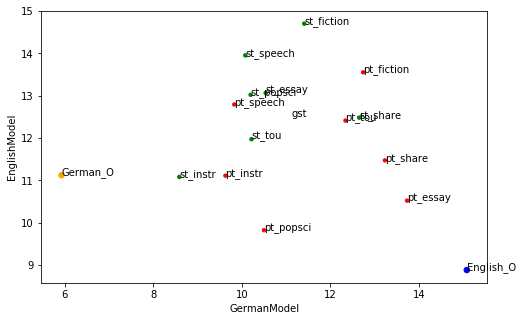

In [204]:
## Finally, we can plot them out!

from matplotlib import pyplot as plt
plt.figure()
c_,s_ = [],[]
for e in diff.iterrows(): 
    focus = e[0]
    if "eo" in focus: 
        c_.append("blue")
        s_.append(30)
    elif "go" in focus: 
        c_.append("orange")
        s_.append(30)
    elif "PT_" in focus: 
        c_.append("red")
        s_.append(11)
    elif "ST_" in focus: 
        c_.append("green")
        s_.append(12)
    else: 
        c_.append("white")
        s_.append(1)
    
    
fig, ax = plt.subplots()

diff.plot(kind="scatter", x="GermanModel", y="EnglishModel", s=s_,
     legend=True, c=c_, title="", ax=ax,figsize=(8,5))

for line in diff.iterrows():
    #xy=(line)
    k=line[0]
    x=line[1][0]
    y=line[1][1]
    xy=(y,x)
    k=k.lower()
    if k=="go": k="German_O"
    if k=="eo": k="English_O"
    if k!="gpr":
        ax.annotate(k, xy)
    #print("\n")
    
#plt.savefig("ptVst.png")

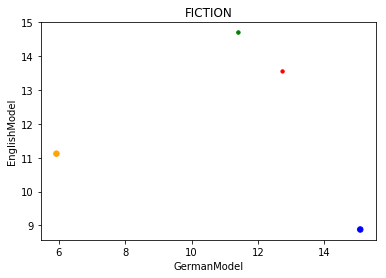

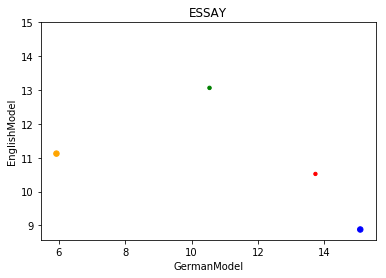

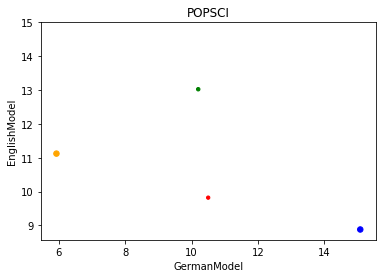

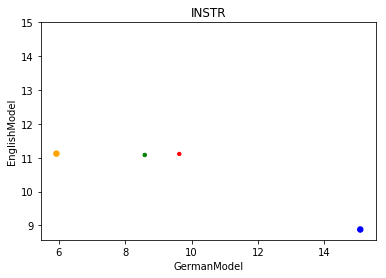

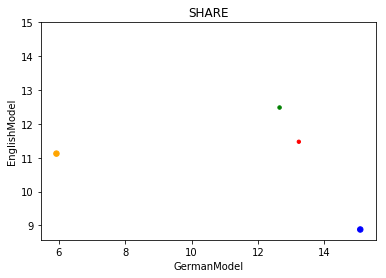

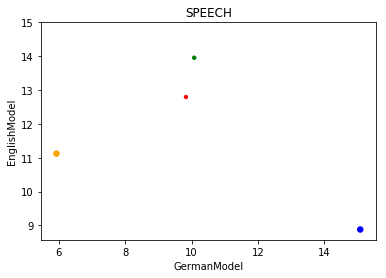

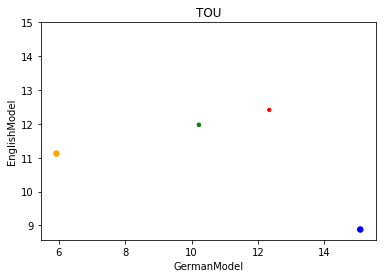

In [205]:
#And we could plot them by category, if we wanted to.

for se in setto:
    #print(se)
    c_,s_ = [],[]
    for e in diff.iterrows(): 
        focus = e[0]
        if "eo" in focus: 
            c_.append("blue")
            s_.append(30)
        elif "go" in focus: 
            c_.append("orange")
            s_.append(30)
        elif "PT_"+se in focus: 
            c_.append("red")
            s_.append(11)
        elif "ST_"+se in focus: 
            c_.append("green")
            s_.append(12)
        else: 
            c_.append("white")
            s_.append(1)
    
    
    diff.plot(kind="scatter", x="GermanModel", y="EnglishModel", s=s_,
     legend=True, c=c_, title=se)

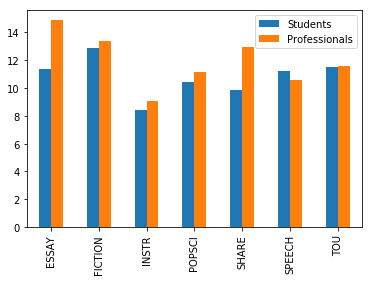

In [207]:
# Another neat way of plotting the German model's surprisal
magic_de.plot(kind='bar')

In [377]:
professional_perplexity


{'FICTION': 33.24359173292073,
 'ESSAY': 15.457289352895087,
 'POPSCI': 11.710792695075131,
 'INSTR': 8.957912740564211,
 'SHARE': 18.00766129516081,
 'SPEECH': 14.62456521016365,
 'TOU': 20.57161489776943}

# Second part of the research: ngram analysis

In [221]:
#stats on POS_ for each register, what are the most frequent trigrams?

categories = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split() 

import nltk
student_frequency = {}
professional_frequency = {}

student_bigram_frequency, professional_bigram_frequency = {},{}

for cat in categories:
    print("\n"+cat)
    names = glob.glob(datdir+"vartra/pos-repres/*CAT_"+cat+"*.txt")
    text = """"""
    for n in names:
        prv = open(n).read()
        text+=prv
    then = text.split()
    fre = nltk.FreqDist(then)
    print(fre.most_common(n=3))
    student_frequency[cat] = fre
    
    bigram = nltk.bigrams(then)
    bi_fre = nltk.FreqDist(bigram)
    print(bi_fre.most_common(3))
    student_bigram_frequency[cat] = bi_fre
    
    names = glob.glob(datdir+"vartra/pos-repres/*PT_"+cat+"*.txt")
    text = """"""
    for n in names:
        prv = open(n).read()
        text+=prv
    then = text.split()
    fre = nltk.FreqDist(then)
    print(fre.most_common(3))
    professional_frequency[cat] = fre
          
    bigram = nltk.bigrams(then)
    bi_fre = nltk.FreqDist(bigram)
    print(bi_fre.most_common(3))
    professional_bigram_frequency[cat] = bi_fre
    
    


FICTION
[('NN', 1850), ('PPER', 1038), ('ART', 950)]
[(('ART', 'NN'), 658), (('ADJA', 'NN'), 427), (('APPR', 'ART'), 300)]
[('NN', 1748), ('$,', 1009), ('PPER', 882)]
[(('ART', 'NN'), 553), (('ADJA', 'NN'), 407), (('NN', '$,'), 291)]

ESSAY
[('NN', 3433), ('ART', 1871), ('ADJA', 1247)]
[(('ART', 'NN'), 1122), (('ADJA', 'NN'), 1045), (('NN', 'APPR'), 626)]
[('NN', 3892), ('ART', 1878), ('ADJA', 1315)]
[(('ART', 'NN'), 1162), (('ADJA', 'NN'), 1095), (('ART', 'ADJA'), 597)]

POPSCI
[('NN', 5244), ('ART', 2605), ('APPR', 1926)]
[(('ART', 'NN'), 1829), (('ADJA', 'NN'), 1283), (('NN', 'APPR'), 948)]
[('NN', 4634), ('ART', 1913), ('ADJA', 1422)]
[(('ART', 'NN'), 1291), (('ADJA', 'NN'), 1211), (('NN', 'VVFIN'), 544)]

INSTR
[('NN', 4516), ('ART', 2270), ('APPR', 1437)]
[(('ART', 'NN'), 1765), (('ADJA', 'NN'), 834), (('APPR', 'ART'), 754)]
[('NN', 5367), ('ART', 2269), ('APPR', 1406)]
[(('ART', 'NN'), 1700), (('ADJA', 'NN'), 975), (('NN', 'APPR'), 665)]

SHARE
[('NN', 5758), ('ART', 2292), ('A

In [222]:
## Mean document and sentence length in characters

student_senlen, professional_senlen = [],[]

for cat in categories:
    print("\n"+cat)
    print("stus")
    names = glob.glob(datdir+"vartra/sent-repres/*CAT_"+cat+"*.vrt")
    text = """"""
    doc_len, sen_len = [],[]
    for n in names:
        #print(n)
        prv = open(n, encoding="latin1").read()
        doc_len.append(len(prv))
        sens = prv.split("\n")
        sens = [len(s) for s in sens]
        sen_len.append(np.mean(sens))
    print(np.mean(doc_len), np.mean(sen_len))
    student_senlen.append(np.mean(sen_len))
    print("pros")
    names = glob.glob(datdir+"vartra/sent-repres/*PT_"+cat+"*.vrt")
    doc_len, sen_len = [],[]
    for n in names:
        prv = open(n, encoding="latin1").read()
        doc_len.append(len(prv))
        sens = prv.split("\n")
        sens = [len(s) for s in sens]
        sen_len.append(np.mean(sens))
    print(np.mean(doc_len), np.mean(sen_len))
    professional_senlen.append(np.mean(sen_len))
    print("\n")
    


FICTION
stus
25475.0 103.96950814406905
pros
22025.666666666668 132.5070220649114



ESSAY
stus
8987.0 154.78850476502473
pros
8859.0 158.15172484864982



POPSCI
stus
27101.833333333332 158.98059944932578
pros
23690.166666666668 138.25161217321065



INSTR
stus
23150.166666666668 119.19018552755695
pros
24228.0 118.42544959206636



SHARE
stus
22238.125 166.44901675728957
pros
22048.25 171.30545070801008



SPEECH
stus
17389.3 142.48839832433345
pros
16859.7 140.33255861226672



TOU
stus
22526.166666666668 142.90706967258754
pros
19794.0 146.96837182656134




In [224]:
symmetric_differences={"language1":[],"language2":[],"ngram":[],"symm_diff":[]}

In [226]:
symmetric_goVpt = []
symmetric_goVst = []

In [227]:

cat = ""
print(cat)

dePOS = poseq(datdir+"croco_for_english_study/GO/*"+cat+"*")
#print(len(dePOS.split("\n")))
#trigrammi banali
n=140000
ngram=7
go_tri = list(nltk.ngrams(dePOS.split()[:n],ngram))
print(len(go_tri))
enPOS = poseq(datdir+"croco_for_english_study/EO/*"+cat+"*")
eo_tri = list(nltk.ngrams(enPOS.split()[:n],ngram))
print(len(eo_tri))
stPOS = poseq(datdir+"croco_for_english_study/ST/*"+cat+"*")
st_tri = list(nltk.ngrams(stPOS.split()[:n],ngram))
print(len(st_tri))
prPOS = poseq(datdir+"croco_for_english_study/PT/*"+cat+"*")
pr_tri = list(nltk.ngrams(prPOS.split()[:n],ngram))
print(len(pr_tri))


139994
139994
139994
139994


In [228]:
go_tri, eo_tri, st_tri, pr_tri = set(go_tri), set(eo_tri), set(st_tri), set(pr_tri)
symmetric_goVpt.append(len(go_tri.symmetric_difference(pr_tri)))
symmetric_goVst.append(len(go_tri.symmetric_difference(st_tri)))

In [230]:
go_fre = nltk.FreqDist(go_tri)
eo_fre = nltk.FreqDist(eo_tri)
#pr_fre = nltk.FreqDist(pr_tri)
#st_fre = nltk.FreqDist(st_tri)

In [232]:
len(go_fre.hapaxes()), len(eo_fre.hapaxes()) #len(pr_fre.hapaxes()),len(st_fre.hapaxes()) 

(98059, 100570)

In [233]:
go_fre.Nr(2), eo_fre.Nr(2) #freq(('DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN'))

(0, 0)

In [234]:
from difflib import SequenceMatcher
SequenceMatcher(None, dePOS[:90000], stPOS[:90000]).ratio() #cioe senti io, boh.

0.058355555555555556

In [235]:
print(len(go_tri.symmetric_difference(eo_tri)),len(go_tri.symmetric_difference(st_tri)), len(go_tri.symmetric_difference(pr_tri)))

178925 140698 143321


In [236]:
len(go_tri.difference(eo_tri)),len(eo_tri.difference(go_tri))

(88207, 90718)

In [237]:
#

In [239]:
#symmetric_differences[str(ngram)] = []

def diffs(diz_ref, diz_con):
    differ = []
    for diz in diz_con:
        differ.append(len(diz_ref.symmetric_difference(diz)))
    return differ

print(len(go_tri.symmetric_difference(eo_tri)),len(go_tri.symmetric_difference(st_tri)), len(go_tri.symmetric_difference(pr_tri)))
cons = {"go":go_tri, "eo":eo_tri, "st":st_tri, "pr":pr_tri}
aha = [k for k in cons.keys()]
lans = cons.values()

for k in cons.keys():
    c = cons[k]
    dif = diffs(c,lans)
    for i in range(len(dif)):
        e=dif[i]
        other=aha[i]
        symmetric_differences["language1"].append(k)
        symmetric_differences["language2"].append(other)
        symmetric_differences["ngram"].append(str(ngram))
        symmetric_differences["symm_diff"].append(e)



178925 140698 143321


In [240]:
diffs(pr_tri,cons.values())

[143321, 173158, 129659, 0]

In [241]:
sim = pd.DataFrame(symmetric_differences)#, index=aha*int((len(symmetric_differences["ngram"])/4)))

In [243]:
def logs(array): 
    ecco = np.log2(np.mean(array))
    return ecco-5

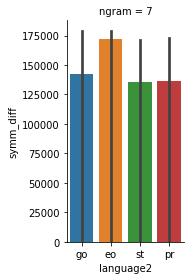

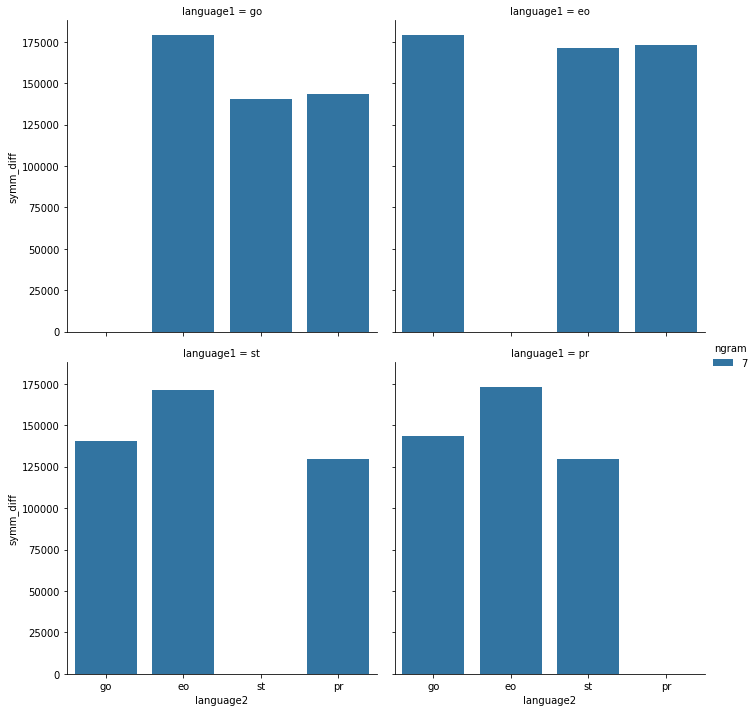

In [246]:
from numpy import median
import seaborn as sns
ax = sns.catplot(x="language2", y="symm_diff",col='ngram', data=sim, estimator=median,height=4, aspect=.7,kind='bar')
sns.catplot('language2','symm_diff',hue='ngram',col='language1',data=sim,kind='bar',col_wrap=2,estimator=np.mean)

In [464]:
#sim

In [247]:
# Question: are students more repetitive in their use of PoS patterns? 

#1. overall (adapted) distance: inner diversity. 
cat=''
n=140000
stu, pro = [],[]
stPOS = poseq(datdir+"croco_for_english_study/ST/*"+cat+"*")
prPOS = poseq(datdir+"croco_for_english_study/PT/*"+cat+"*")
for ngram in range(1,8):
    print(ngram)
    st_tri = list(nltk.ngrams(stPOS.split()[:n],ngram))
    se = set(st_tri)
    print("student var", len(se))
    stu.append(len(se))
    pr_tri = list(nltk.ngrams(prPOS.split()[:n],ngram))
    se = set(pr_tri)
    print("professional var", len(se))
    pro.append(len(se))
    


1
student var 16
professional var 16
2
student var 221
professional var 224
3
student var 2004
professional var 2072
4
student var 10293
professional var 10785
5
student var 29934
professional var 31555
6
student var 58956
professional var 61849
7
student var 89459
professional var 92642


In [248]:
#2. register distance
categories = """FICTION ESSAY POPSCI INSTR SHARE SPEECH TOU""".split()

inndiv_st, inndiv_pr = {},{}

inndiv_eo = {}
inndiv_go = {}

for cat in categories:
    print(cat)
    inndiv_st[cat] = []
    inndiv_pr[cat] = []
    inndiv_go[cat] = []
    inndiv_eo[cat] = []
    
    
    stPOS = poseq(datdir+"croco_for_english_study/ST/*"+cat+"*")
    prPOS = poseq(datdir+"croco_for_english_study/PT/*"+cat+"*")
    
    eoPOS = poseq(datdir+"croco_for_english_study/EO/*"+cat+"*")
    goPOS = poseq(datdir+"croco_for_english_study/GO/*"+cat+"*")
    
    n=min(len(stPOS), len(prPOS))-100
    print(n)
    prv_st, prv_pr = [],[]
    for ngram in range(1,8):
        st_tri = list(nltk.ngrams(stPOS.split()[:n],ngram))
        se = set(st_tri)
        inndiv_st[cat].append(len(se))
        
        pr_tri = list(nltk.ngrams(prPOS.split()[:n],ngram))
        se = set(pr_tri)
        inndiv_pr[cat].append(len(se))
        
        go_tri = list(nltk.ngrams(goPOS.split()[:n],ngram))
        se = set(go_tri)
        inndiv_go[cat].append(len(se))
        
        eo_tri = list(nltk.ngrams(eoPOS.split()[:n],ngram))
        se = set(eo_tri)
        inndiv_eo[cat].append(len(se))
        
        
sanity_check = []
        
for cat in categories:
    print(cat)
    st_=inndiv_st[cat]
    pr_=inndiv_pr[cat]
    sanity_check.append(pr_[-1])
    print(st_)
    print(pr_)
    print("\n")

FICTION
62770
ESSAY
77863
POPSCI
111221
INSTR
101314
SHARE
122541
SPEECH
120315
TOU
99227
FICTION
[15, 179, 1138, 3558, 6702, 9514, 11303]
[15, 198, 1556, 6622, 15434, 24827, 31781]


ESSAY
[15, 184, 1202, 3762, 7420, 11003, 13634]
[15, 195, 1493, 5652, 12661, 20740, 27540]


POPSCI
[15, 185, 1324, 4568, 9538, 14756, 18816]
[15, 205, 1563, 6071, 13604, 21793, 28081]


INSTR
[16, 199, 1262, 4028, 8130, 12268, 15498]
[16, 207, 1514, 5428, 11831, 18963, 24885]


SHARE
[16, 196, 1347, 4757, 10128, 15908, 20479]
[16, 208, 1566, 6110, 13840, 22543, 29511]


SPEECH
[15, 191, 1343, 4672, 9933, 15568, 20030]
[15, 190, 1471, 5727, 13096, 21562, 28650]


TOU
[15, 179, 1201, 4115, 8649, 13423, 16960]
[16, 193, 1411, 5519, 12876, 21238, 27741]




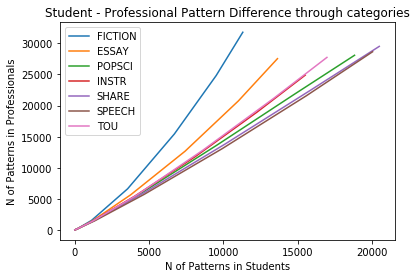

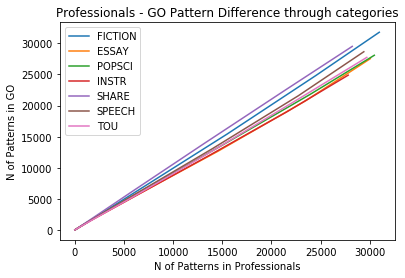

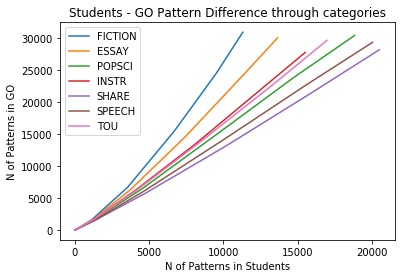

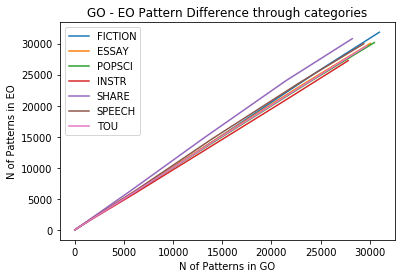

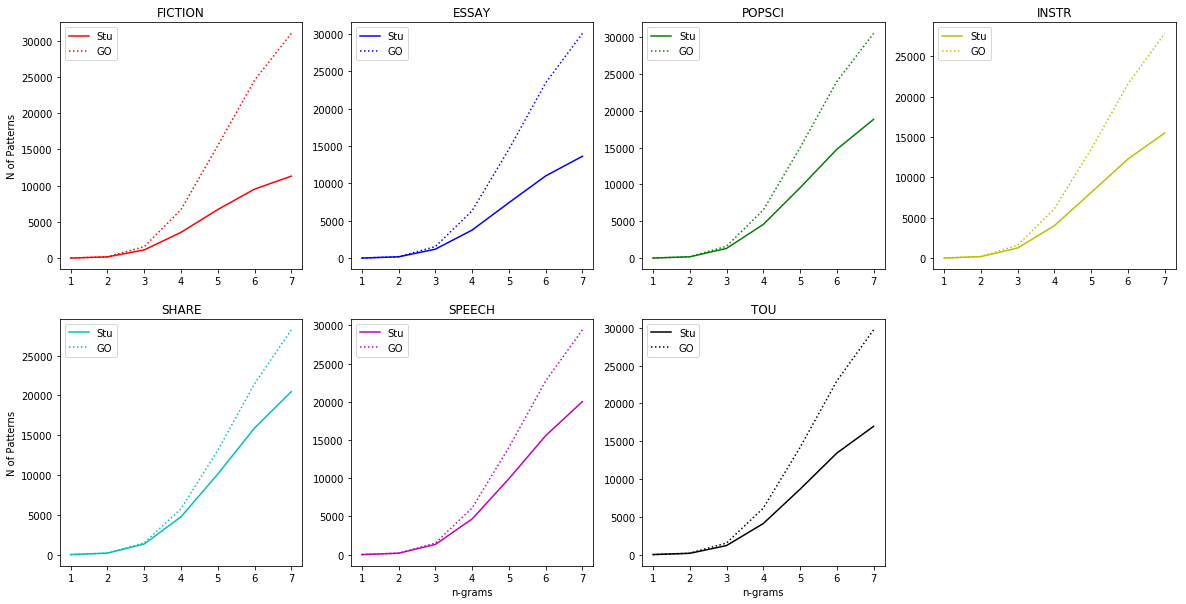

In [249]:
# 3. difference in patterns in growing ngrams

from matplotlib import pyplot as plt

#
basis = [1,2,3,4,5,6,7]

for cat in categories:
    #print(cat)
    stu_ = inndiv_st[cat]
    pro_ = inndiv_pr[cat]
    plt.plot(stu_,pro_,label=cat)  
    #print("\n")

plt.xlabel('N of Patterns in Students')
plt.ylabel('N of Patterns in Professionals')
plt.title('Student - Professional Pattern Difference through categories')
plt.legend()
plt.savefig("/Users/yuribizzoni/Stu_Pro.png")
plt.show()

#plt.subplot(2,4,2)
for cat in categories:
    #print(cat)
    go_ = inndiv_go[cat]
    pro_ = inndiv_pr[cat]
    plt.plot(go_,pro_,label=cat)  
    #print("\n")

plt.xlabel('N of Patterns in Professionals')
plt.ylabel('N of Patterns in GO')
plt.title('Professionals - GO Pattern Difference through categories')
plt.legend()
plt.savefig("/Users/yuribizzoni/Pro_GO.png")
plt.show()

#plt.subplot(2,4,3)
for cat in categories:
    #print(cat)
    stu_ = inndiv_st[cat]
    go_ = inndiv_go[cat]
    plt.plot(stu_,go_,label=cat)  
    #print("\n")

plt.xlabel('N of Patterns in Students')
plt.ylabel('N of Patterns in GO')
plt.title('Students - GO Pattern Difference through categories')
plt.legend()
plt.savefig("/Users/yuribizzoni/Stu_Go.png")
plt.show()

#plt.subplot(2,4,4)
for cat in categories:
    #print(cat)
    stu_ = inndiv_go[cat]
    pro_ = inndiv_eo[cat]
    plt.plot(stu_,pro_,label=cat)  
    #print("\n")

plt.xlabel('N of Patterns in GO')
plt.ylabel('N of Patterns in EO')
plt.title('GO - EO Pattern Difference through categories')
plt.legend()
plt.savefig("/Users/yuribizzoni/Stu_Pro2.png")
plt.show()

#plt.savefig("/Users/yuribizzoni/four_comparisons.png")

#Notice the differences in the x axis


#can i even do this?

cols = 'r b g y c m k'.split()
e,j=0,1

fig = plt.figure(figsize=(20,10))

for i in range(len(categories)):
    cat=categories[i]
    #print(cat)
    stu_ = inndiv_st[cat]
    pro_ = inndiv_pr[cat]
    go_ = inndiv_go[cat]
    plt.subplot(2,4,j)
    j+=1
    plt.plot(basis,stu_,label="Stu", color=cols[e],linestyle='-') 
    plt.plot(basis,go_,label="GO", color=cols[e],linestyle=':')
    plt.title(cat)
    e+=1
    #print("\n")
    plt.legend()  
    if i>4: plt.xlabel('n-grams')
    if i==0 or i==4: plt.ylabel('N of Patterns')
#plt.title('Student - Professional Pattern Difference through categories')
plt.legend()  
plt.savefig("/Users/yuribizzoni/Stu_Pro_Cats.png")
plt.show()   
    